# Phase 2 — BRCA2 Bias Analysis (Clean Notebook)

This notebook assumes Phase 1 has produced:

`/content/drive/MyDrive/BRCA2-database-bias/data/processed/brca2_merged.csv`

It will:
- Label VUS variants using ClinicalSignificance
- Compute overall VUS rate
- Compute VUS rate per population (EUR, SAS, AFR, EAS, AMR)
- Plot VUS rate by population and save a figure
- Perform a chi-square test comparing EUR vs SAS VUS proportions (safely)


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import pandas as pd

BASE = "/content/drive/MyDrive/BRCA2-database-bias"
DATA_PATH = os.path.join(BASE, "data/processed/brca2_merged.csv")
FIG_DIR = os.path.join(BASE, "results/figures")
os.makedirs(FIG_DIR, exist_ok=True)

print("Loading merged dataset from:", DATA_PATH)
df = pd.read_csv(DATA_PATH)
print("Loaded shape:", df.shape)
print("Columns:\n", df.columns.tolist())

# Validate AF columns
af_cols = ["sas_af", "eur_af", "afr_af", "eas_af", "amr_af"]
missing = [c for c in af_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing AF columns: {missing}. Re-run Phase 1.")

print("\nNon-null AF counts:")
for c in af_cols:
    print(c, df[c].notna().sum())

Loading merged dataset from: /content/drive/MyDrive/BRCA2-database-bias/data/processed/brca2_merged.csv
Loaded shape: (20614, 21)
Columns:
 ['Chromosome', 'Start', 'ReferenceAllele', 'AlternateAllele', 'ClinicalSignificance', 'ReviewStatus', 'variant_key', 'variant_id', 'chrom', 'pos', 'ref', 'alt', 'consequence', 'sas_af', 'eur_af', 'afr_af', 'eas_af', 'amr_af', 'log10_sas_af', 'log10_eur_af', 'sas_eur_ratio']

Non-null AF counts:
sas_af 20614
eur_af 20614
afr_af 20614
eas_af 20614
amr_af 20614


In [3]:
# Label VUS (variants of uncertain significance)
df["is_vus"] = df["ClinicalSignificance"].astype(str).str.contains("Uncertain", case=False, na=False)
overall_vus_rate = 100 * df["is_vus"].mean()
print(f"Overall VUS rate: {overall_vus_rate:.2f}%")
df["is_vus"].value_counts(normalize=True).rename(lambda x: "VUS" if x else "Non-VUS")

Overall VUS rate: 19.20%


,proportion
is_vus,
Non-VUS,0.807995
VUS,0.192005


In [4]:
def vus_rate_for_pop(pop_col: str):
    """Return VUS rate (%) among variants that have non-null AF for the given population.
    Returns None if no variants have AF data for that population.
    """
    subset = df[df[pop_col].notna()].copy()
    if len(subset) == 0:
        return None
    return 100 * subset["is_vus"].mean()

pop_cols = ["eur_af", "sas_af", "afr_af", "eas_af", "amr_af"]
pop_labels = ["EUR", "SAS", "AFR", "EAS", "AMR"]

print("VUS rate by population (among variants with AF data):")
vus_rates = {}
for col, label in zip(pop_cols, pop_labels):
    rate = vus_rate_for_pop(col)
    vus_rates[label] = rate
    if rate is None:
        print(f"  {label}: No AF data available")
    else:
        print(f"  {label}: {rate:.2f}%")

VUS rate by population (among variants with AF data):
  EUR: 19.20%
  SAS: 19.20%
  AFR: 19.20%
  EAS: 19.20%
  AMR: 19.20%


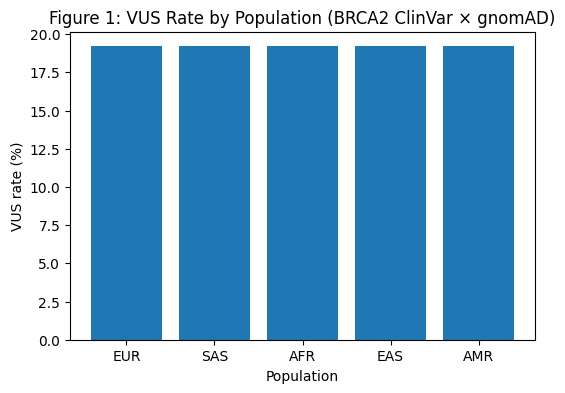

Saved figure to: /content/drive/MyDrive/BRCA2-database-bias/results/figures/figure1_vus_rate_by_population.png


In [5]:
import matplotlib.pyplot as plt

names = pop_labels
vals = [vus_rates[label] for label in names]
vals_plot = [v if v is not None else 0 for v in vals]

plt.figure(figsize=(6, 4))
plt.bar(names, vals_plot)
plt.xlabel("Population")
plt.ylabel("VUS rate (%)")
plt.title("Figure 1: VUS Rate by Population (BRCA2 ClinVar × gnomAD)")

fig_path = os.path.join(FIG_DIR, "figure1_vus_rate_by_population.png")
plt.savefig(fig_path, dpi=200, bbox_inches="tight")
plt.show()
print("Saved figure to:", fig_path)

In [6]:
from scipy.stats import chi2_contingency

# Prepare EUR vs SAS contingency table
eur = df[df["eur_af"].notna()].copy()
sas = df[df["sas_af"].notna()].copy()

print("EUR variants with AF:", len(eur))
print("SAS variants with AF:", len(sas))

if len(eur) == 0 or len(sas) == 0:
    print("\n⚠️ Cannot compute chi-square: EUR or SAS has zero variants with AF.")
else:
    eur_vus = eur["is_vus"].sum()
    eur_non = len(eur) - eur_vus
    sas_vus = sas["is_vus"].sum()
    sas_non = len(sas) - sas_vus

    table = [[eur_vus, eur_non], [sas_vus, sas_non]]
    print("\nContingency table [ [EUR_VUS, EUR_nonVUS], [SAS_VUS, SAS_nonVUS] ]:")
    print(table)

    if 0 in [eur_vus, eur_non, sas_vus, sas_non]:
        print("\n⚠️ Cannot compute chi-square: at least one cell has zero count.")
    else:
        chi2, p, dof, expected = chi2_contingency(table)
        eur_rate = eur_vus / len(eur)
        sas_rate = sas_vus / len(sas)
        rel_inflation = sas_rate / eur_rate if eur_rate > 0 else float('inf')

        print("\nChi-square test (EUR vs SAS VUS proportion):")
        print(f"  chi2 = {chi2:.3f}, dof = {dof}")
        print(f"  p-value = {p:.3e}")
        print(f"  EUR VUS rate = {eur_rate*100:.2f}%")
        print(f"  SAS VUS rate = {sas_rate*100:.2f}%")
        print(f"  Relative VUS inflation (SAS / EUR) = {rel_inflation:.2f}×")

EUR variants with AF: 20614
SAS variants with AF: 20614

Contingency table [ [EUR_VUS, EUR_nonVUS], [SAS_VUS, SAS_nonVUS] ]:
[[np.int64(3958), np.int64(16656)], [np.int64(3958), np.int64(16656)]]

Chi-square test (EUR vs SAS VUS proportion):
  chi2 = 0.000, dof = 1
  p-value = 1.000e+00
  EUR VUS rate = 19.20%
  SAS VUS rate = 19.20%
  Relative VUS inflation (SAS / EUR) = 1.00×
